# № 5 Аптеки и выручка

**Формулировка гипотезы**

H₀: Средний чек не зависит от аптеки.  
H₁: Средний чек зависит от аптеки — существуют аптеки, где он статистически выше или ниже среднего уровня.

**Тесты**   
- ANOVA (предпосылки не выполнены, тест не проводился)
    - Shapiro–Wilk test
    - Kolmogorov–Smirnov test
    - Bartlett's test
    - Levene's test
- Kruskal–Wallis test
    - Пост-хок Dunn test (Bonferroni)
    - Размер эффекта Eta squared
    - Размер эффекта Epsilon squared

### Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
import configparser
import scipy.stats as stats
from scipy.stats import kruskal
import scikit_posthocs as sp
from statsmodels.graphics.gofplots import qqplot
from itertools import combinations
 # Импортируем класс из файла db_connection.py
from db_connection import PostgresConnection
# Импортируем класс из файла data_cleaner.py
from data_cleaner import DataCleaner

In [2]:
# Создаем объект для работы с базой данных
db_connection = PostgresConnection()

query = 'SELECT * FROM sales'
data = db_connection.execute_query(query)

### Подготовка данных

In [3]:
# Создаем объект DataCleaner с данным DataFrame
cleaner = DataCleaner(data)

# Удаляем строки с отрицательными значениями в 'dr_sdisc' и 'dr_kol'
cleaned_data = cleaner.drop_negative_values()

# Удаляем строки, где 'dr_nchk' имеет значения из списка [21, 593, 2495]
cleaned_data = cleaner.drop_error_check_values()

### Формирование чеков

In [4]:
cleaned_data['price_without_discount'] = cleaned_data['dr_croz'] * cleaned_data['dr_kol']
grouped = cleaned_data.groupby(['dr_tabempl', 'dr_apt', 'dr_nchk', 'dr_dat']).agg({'price_without_discount':'sum',\
                                                            'dr_sdisc':'max', 'dr_tpay':'max'}).reset_index()
grouped['final_price'] = grouped['price_without_discount'] - grouped['dr_sdisc']
grouped.head()

,dr_tabempl,dr_apt,dr_nchk,dr_dat,price_without_discount,dr_sdisc,dr_tpay,final_price
0,15,11,2491,2022-05-03,8706.0,0.0,15,8706.0
1,15,11,2497,2022-05-04,2677.0,0.0,18,2677.0
2,15,11,2499,2022-05-04,2150.0,0.0,18,2150.0
3,15,11,2501,2022-05-04,959.0,0.0,18,959.0
4,15,11,2503,2022-05-04,1194.0,0.0,18,1194.0


### EDA

**Статистика по группам**

In [5]:
grouped.groupby('dr_apt')['final_price'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

,dr_apt,mean,median,count
0,2,794.70,455.0,3169
1,6,759.51,416.0,2083
2,7,442.03,221.0,1516
3,11,545.69,297.0,3017
4,13,589.54,338.0,2151
5,15,529.30,301.0,1980
6,17,591.80,368.5,2226
7,18,454.40,244.0,4840


**Визуализация распределений**

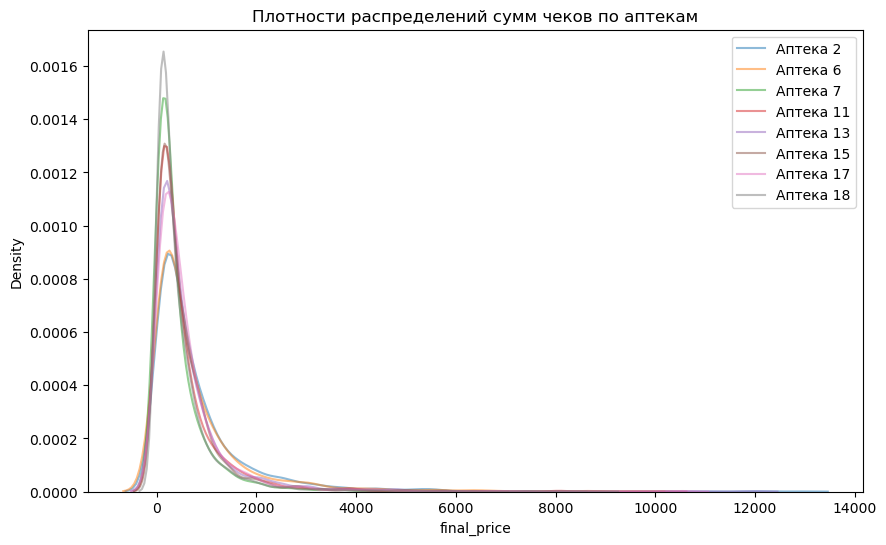

In [6]:
# Группировка по сотрудникам
groups = grouped.groupby('dr_apt')['final_price']

# 1. -- Визуализация плотностей KDE
plt.figure(figsize=(10, 6))
for name, group in groups:
    sns.kdeplot(group, label=f"Аптека {name}", alpha=0.5)
plt.title("Плотности распределений сумм чеков по аптекам")
plt.xlabel("final_price")
#plt.legend()
plt.legend(loc='best')
plt.show()

- Все кривые имеют пик вблизи нуля – нескольких сотен рублей, следовательно большинство чеков в обеих группах находятся в этой зоне.
- Хвосты (справа) длинные, есть редкие большие чеки (до 14 000).
- Форма во всех группах очень похожа: узкий высокий пик + длинный правый хвост.

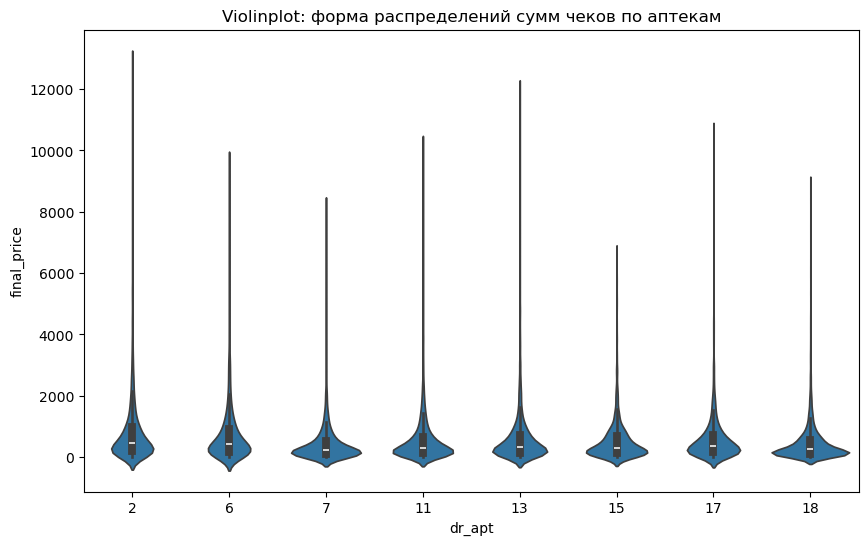

In [7]:
# 2. -- Violinplot — форма распределения (сглаженная плотность)
plt.figure(figsize=(10, 6))
sns.violinplot(x="dr_apt", y="final_price", data=grouped)
plt.title("Violinplot: форма распределений сумм чеков по аптекам")
plt.show()

1. Форма распределений схожа у всех аптек:
- У всех аптек плотность распределена неравномерно: максимум приходится на низкие значения (200–500).
- Распределения асимметричны с длинным "хвостом" вверх — это говорит о редких, но больших чеках.
- "Тело" (широкая часть) у всех аптек расположено в нижней части оси.

2. Средние и медианные значения визуально находятся близко друг к другу (показаны белыми точками и прямоугольниками).

3. Форма — "грушевидная" или "каплевидная" почти у всех аптек — это типичная форма положительно скошенного распределения (right-skewed).

4. Незначительные различия.
- Некоторые аптеки (например, аптека 2 и 13) имеют чуть более длинный хвост — это может означать, что в этих аптеках чуть чаще встречаются крупные продажи.
- Аптека 15 выглядит немного менее "вытянутой", т.е. большие чеки там встречаются реже.
- Ширина "тела" (частота продаж в основном диапазоне) немного варьируется — например, аптека 6 чуть плотнее в районе 300–600, чем аптека 11.

**Интерпретация результатов**   
Распределения сумм чеков по аптекам в целом имеют схожую форму: они положительно скошены, с плотным ядром в районе малых значений и длинными хвостами в сторону больших сумм. Это указывает на общую модель поведения покупателей, независимо от аптеки: большинство транзакций — на небольшие суммы, а редкие покупки — значительно дороже. Незначительные различия в плотности и хвостах могут указывать на особенности ассортимента или клиентской базы отдельных аптек.

## ANOVA

### Проверка предпосылок

In [8]:
# ============================
# 1. Проверка предпосылок
# ============================

print("=== Проверка нормальности (Shapiro + KS) ===")
for day, group in grouped.groupby("dr_apt"):
    stat_shapiro, p_shapiro = stats.shapiro(group["final_price"])
    mean, std = group["final_price"].mean(), group["final_price"].std()
    stat_ks, p_ks = stats.kstest(group["final_price"], "norm", args=(mean, std))
 
    print(f"\nАптека: {day}")
    print(f"Shapiro-Wilk: stat={stat_shapiro:.4f}, p={p_shapiro:.4f}")
    print(f"Kolmogorov-Smirnov: stat={stat_ks:.4f}, p={p_ks:.4f}")
    
    
# Проверка гомогенности дисперсий
groups = [group["final_price"].values for _, group in grouped.groupby("dr_apt")]
 
print("\n=== Проверка гомогенности дисперсий (Bartlett's test + Levene's test) ===")
stat_levene, p_levene = stats.levene(*groups)
stat_bartlett, p_bartlett = stats.bartlett(*groups)
print(f"Levene: stat={stat_levene:.4f}, p={p_levene:.4f}")
print(f"Bartlett: stat={stat_bartlett:.4f}, p={p_bartlett:.4f}")

=== Проверка нормальности (Shapiro + KS) ===

Аптека: 2
Shapiro-Wilk: stat=0.6509, p=0.0000
Kolmogorov-Smirnov: stat=0.2260, p=0.0000

Аптека: 6
Shapiro-Wilk: stat=0.6417, p=0.0000
Kolmogorov-Smirnov: stat=0.2341, p=0.0000

Аптека: 7
Shapiro-Wilk: stat=0.5645, p=0.0000
Kolmogorov-Smirnov: stat=0.2577, p=0.0000

Аптека: 11
Shapiro-Wilk: stat=0.6008, p=0.0000
Kolmogorov-Smirnov: stat=0.2400, p=0.0000

Аптека: 13
Shapiro-Wilk: stat=0.6327, p=0.0000
Kolmogorov-Smirnov: stat=0.2273, p=0.0000

Аптека: 15
Shapiro-Wilk: stat=0.6575, p=0.0000
Kolmogorov-Smirnov: stat=0.2211, p=0.0000

Аптека: 17
Shapiro-Wilk: stat=0.5922, p=0.0000
Kolmogorov-Smirnov: stat=0.2348, p=0.0000

Аптека: 18
Shapiro-Wilk: stat=0.6177, p=0.0000
Kolmogorov-Smirnov: stat=0.2347, p=0.0000

=== Проверка гомогенности дисперсий (Bartlett's test + Levene's test) ===
Levene: stat=49.1742, p=0.0000
Bartlett: stat=1557.6819, p=0.0000


Проверка нормальности (Shapiro-Wilk и Kolmogorov-Smirnov):  
- По результатам тестов Шапиро-Уилка и Колмогорова-Смирнова, распределения сумм чеков во всех аптеках статистически значимо отклоняются от нормального распределения (p < 0.05). Следовательно, предпосылки нормальности нарушены, что делает использование параметрических методов анализа (ANOVA) некорректным без преобразования данных.  

Проверка гомогенности дисперсий (Levene's и Bartlett's tests):  
- Результаты тестов Левена (p = 0.0000) и Бартлетта (p = 0.0000) свидетельствуют о статистически значимых различиях в дисперсиях между аптеками, то есть условие гомогенности дисперсий нарушено.  

**Интерпретация результатов**  
Так как распределения ненормальны и дисперсии неоднородны, для анализа различий между аптеками следует использовать непараметрические методы Kruskal-Wallis и пост-хок Dunn’s test.

## Kruskal–Wallis test 

### Проверка предпосылок

На основании kdeplot и Violinplot можно утверждать, что предпосылка Kruskal-Wallis о примерно одинаковой форме распределений соблюдена.

### Проведение теста

In [9]:
# ============================
# 1. Kruskal-Wallis
# ============================

# 1. Kruskal-Wallis
groups = [df["final_price"].values for _, df in grouped.groupby("dr_apt")]
stat, p = kruskal(*groups)
print("\n=== Kruskal-Wallis H-test ===")
print(f"Kruskal-Wallis H-test: stat={stat:.3f}, p={p:.5f}")

# ============================
# 2. Пост-хок анализ (если H0 отвергнута)
# ============================

posthoc_results_apt = sp.posthoc_dunn(grouped, val_col='final_price', group_col='dr_apt', p_adjust='bonferroni')

# ============================
# 3. Eta squared (η²)
# ============================

n = len(grouped)          # общее количество наблюдений
k = len(groups)      # число групп

# 3. Eta squared (η²)
eta_sq = (stat - k + 1) / (n - k)

# ============================
# 4. Epsilon squared (ε²)
# ============================

# 4. Epsilon squared (ε²)
epsilon_sq = stat / (n - 1)

print("\n=== Сила эффекта ===")
print(f"Eta² = {eta_sq:.4f}")
print(f"Epsilon² = {epsilon_sq:.4f}")


=== Kruskal-Wallis H-test ===
Kruskal-Wallis H-test: stat=621.651, p=0.00000

=== Сила эффекта ===
Eta² = 0.0293
Epsilon² = 0.0296


**Интерпретация результатов**
- Значение p < 0.05 указывает на то, что различия в выручке между аптеками статистически значимы, и гипотеза H₀ (об отсутствии различий) отвергается.
- Однако показатели силы эффекта (~0.03) свидетельствуют о слабом размере эффекта, то есть различия между аптеками существуют, но они объясняют лишь небольшую долю общей вариации в данных.

### Визуализация результатов

**Визуализация распределения аптек по доле значимых сравнений**

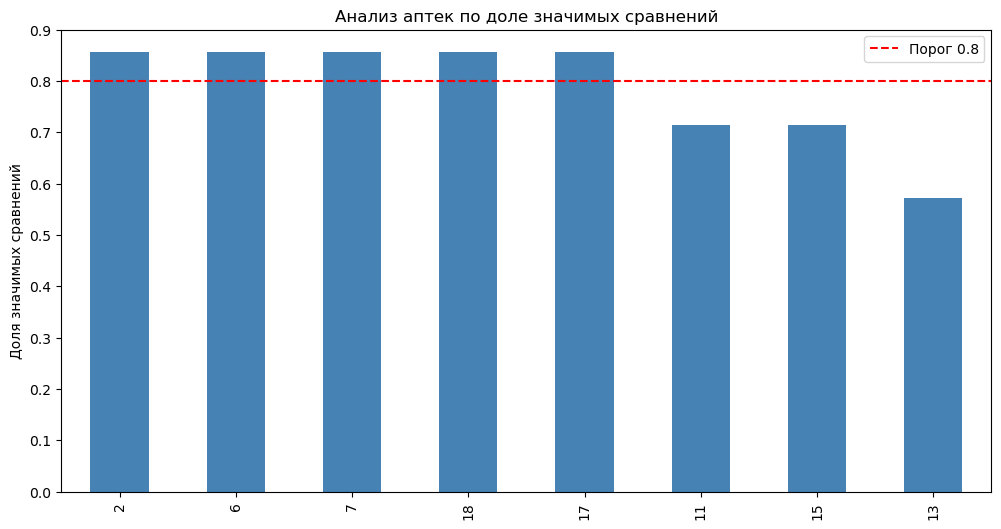

In [10]:
alpha = 0.05

# Бинарная матрица: значимые различия (1) / нет (0)
binary_matrix = (posthoc_results_apt < alpha).astype(int)

# Доля значимых сравнений для каждого сотрудника
significance_ratio = binary_matrix.sum(axis=1) / (binary_matrix.shape[1] - 1)

# Сортируем для удобства
significance_ratio_sorted = significance_ratio.sort_values(ascending=False)

# Построим график
plt.figure(figsize=(12,6))
significance_ratio_sorted.plot(kind="bar", color="steelblue")
plt.axhline(0.8, color="red", linestyle="--", label="Порог 0.8")
plt.ylabel("Доля значимых сравнений")
plt.title("Анализ аптек по доле значимых сравнений")
plt.legend()
plt.show()

**Результаты**  

Статистический тест Kruskal–Wallis показал значение p < 0.05. Это указывает на то, что различия в выручке между аптеками статистически значимы, и гипотеза H₀ (об отсутствии различий) отвергается. Однако показатели силы эффекта (~0.03) свидетельствуют о слабом размере эффекта, то есть различия между аптеками существуют, но они объясняют лишь небольшую долю общей вариации в данных.

Пост-хок анализ показал, что аптеки № 2, 6, 7, 17 и 18 статистически значимо отличаются по уровню выручки от большинства остальных (различия наблюдаются более чем в 80% попарных сравнений). Эти аптеки являются ключевыми точками отклонения. Рекомендуется провести их детальный аудит: для успешных аптек — с целью выявления и масштабирования факторов успеха, для отстающих — для устранения узких мест.

1. Аптеки №2 и №6
- Средний чек очень высокий (≈ 760–795 руб.),
- Но медиана сильно ниже (≈ 416–455 руб.),
- Значит, распределение продаж скошено: есть небольшое число крупных чеков, сильно тянущих среднее вверх.
- Эти аптеки не просто успешные — они, скорее всего, обслуживают особый сегмент (например, корпоративные закупки, дорогостоящие препараты).
2. Аптека №7 и №18
- Средний чек низкий (≈ 442–454 руб.),
- Медиана ещё ниже (≈ 221–244 руб.),
- При этом количество чеков большое (особенно у №18 — почти 5000).
- Это указывает на большой поток покупателей, но каждый чек небольшой, аптеки ориентированы на массовый сегмент, недорогие товары, "повседневные покупки".
3. Аптеки №11, №13, №15, №17
- Средний чек в диапазоне 529–592 руб.,
- Медиана 301–369 руб.
- Баланс между ценой и количеством чеков, без явных аномалий.
- Это можно считать "нормальной группой" с типичным профилем продаж.

Пост-хок анализ и статистика продаж показали, что аптеки №2 и №6 значительно выделяются за счёт высокого среднего чека при умеренной медиане — вероятно, они формируют выручку за счёт отдельных крупных продаж (например, дорогостоящих препаратов или оптовых заказов).

В противоположность им, аптеки №7 и №18 работают по массовой модели: они привлекают много клиентов, но средний чек остаётся низким, что указывает на специализацию в сегменте недорогих товаров.

Остальные аптеки (№11, №13, №15, №17) имеют более сбалансированный профиль и представляют собой «среднюю норму» сети.

**Значение для бизнеса**  
Средний чек статистически значимо зависит от аптеки, но размер эффекта слабый (η² ≈ 0.03). Это означает, что аптека действительно влияет на величину среднего чека, однако различия между точками не являются ключевым драйвером выручки — основное влияние оказывают другие факторы (например, индивидуальные особенности сотрудников или структура продаж).  
Различия между аптеками существуют, но они не указывают на системные проблемы в ценообразовании или продажах. Возможное направление анализа — изучение факторов, которые делают отдельные аптеки более прибыльными (локация, клиентский поток, состав корзины).

**Рекомендации:**
- Для аптек №2 и №6 — изучить источники крупных чеков и рассмотреть возможность масштабирования (например, выделение premium-направления).
- Для аптек №7 и №18 — усилить стратегию повышения среднего чека (дополнительные продажи, апсейл, промо-пакеты).
- Для аптек со «средним профилем» — использовать как бенчмарк для выработки стандартов сети.